In [3]:
import sklearn
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [30]:
content = pd.read_csv("E:/ML/DS_fake_news/fake_news_cleaned_filtered.csv", nrows=100000, usecols=['0'])
label_map = {'bias': 0,
                        'clickbait': 0,
                        'conspiracy': 0,
                        'fake': 1,
                        'hate': 1,
                        'junksci': 1,
                        'political': 0,
                        'reliable': 0,
                        'rumor': 0,
                        'satire': 0,
                        'unreliable': 1}
labels = pd.read_csv("E:/ML/DS_fake_news/fake_news_cleaned.csv", nrows=100000, usecols=['type'])
labels['type'] = labels['type'].map(label_map)
dataset = pd.concat([content, labels], axis=1)

In [31]:
dataset = dataset[(dataset['type'] == 0) | (dataset['type'] == 1)]

In [32]:
import ast
dataset['0'] = dataset['0'].apply(ast.literal_eval)

In [33]:
dataset.groupby("type").count()

,0
type,
0.0,46107
1.0,49315


In [34]:
all_words = [word for tokens in dataset["0"] for word in tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

33903525 words total, with a vocabulary size of 397463


In [35]:
# make "content" column, which is just a string of the tokens
dataset['content'] = dataset['0'].apply(lambda x: ' '.join(x))

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

def cv(data):
    #vectorizer = CountVectorizer()

    #emb = vectorizer.fit_transform(data)
    
    vectorizer = HashingVectorizer(n_features=2**20, stop_words='english')
    emb = vectorizer.transform(data)
    
    return emb, vectorizer


In [9]:
list_corpus = dataset["content"].tolist()
list_labels = dataset["type"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, vectorizer = cv(X_train)
X_test_counts = vectorizer.transform(X_test)

In [10]:
X_test_counts.shape[1]

1048576

In [11]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Fake news')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

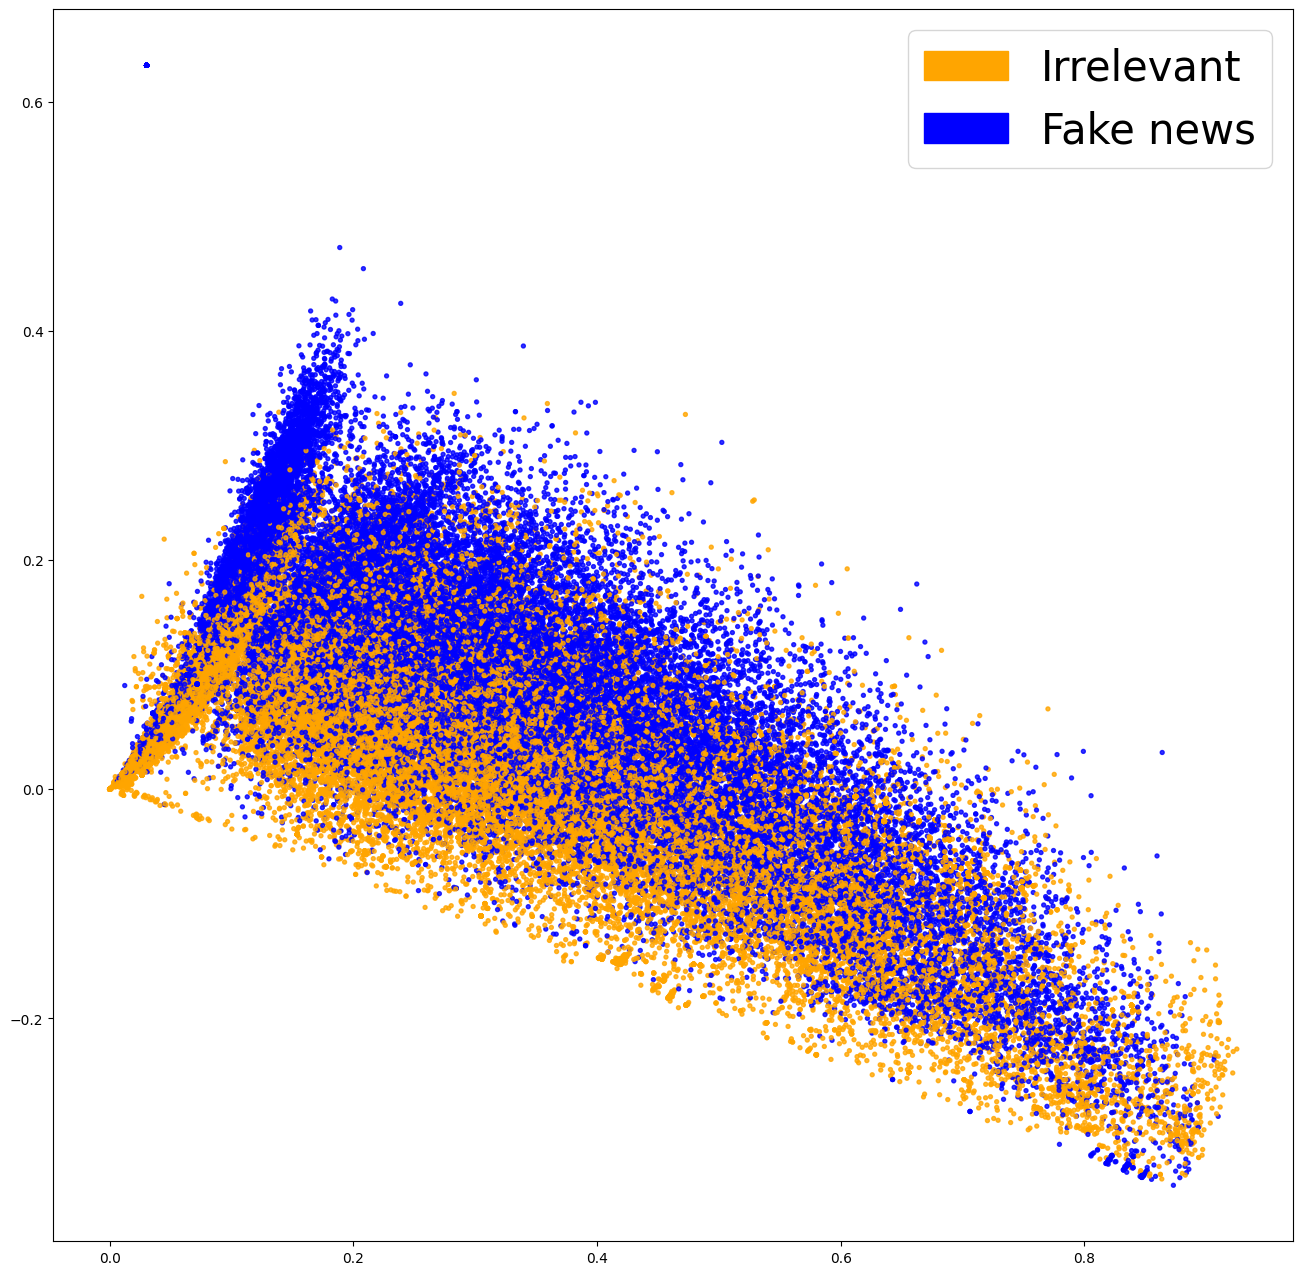

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [49]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.964, precision = 0.965, recall = 0.964, f1 = 0.964


In [37]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "E:/ML/DS_fake_news/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [38]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['0'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [39]:
embeddings = get_word2vec_embeddings(word2vec, dataset)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

NameError: name 'list_labels' is not defined

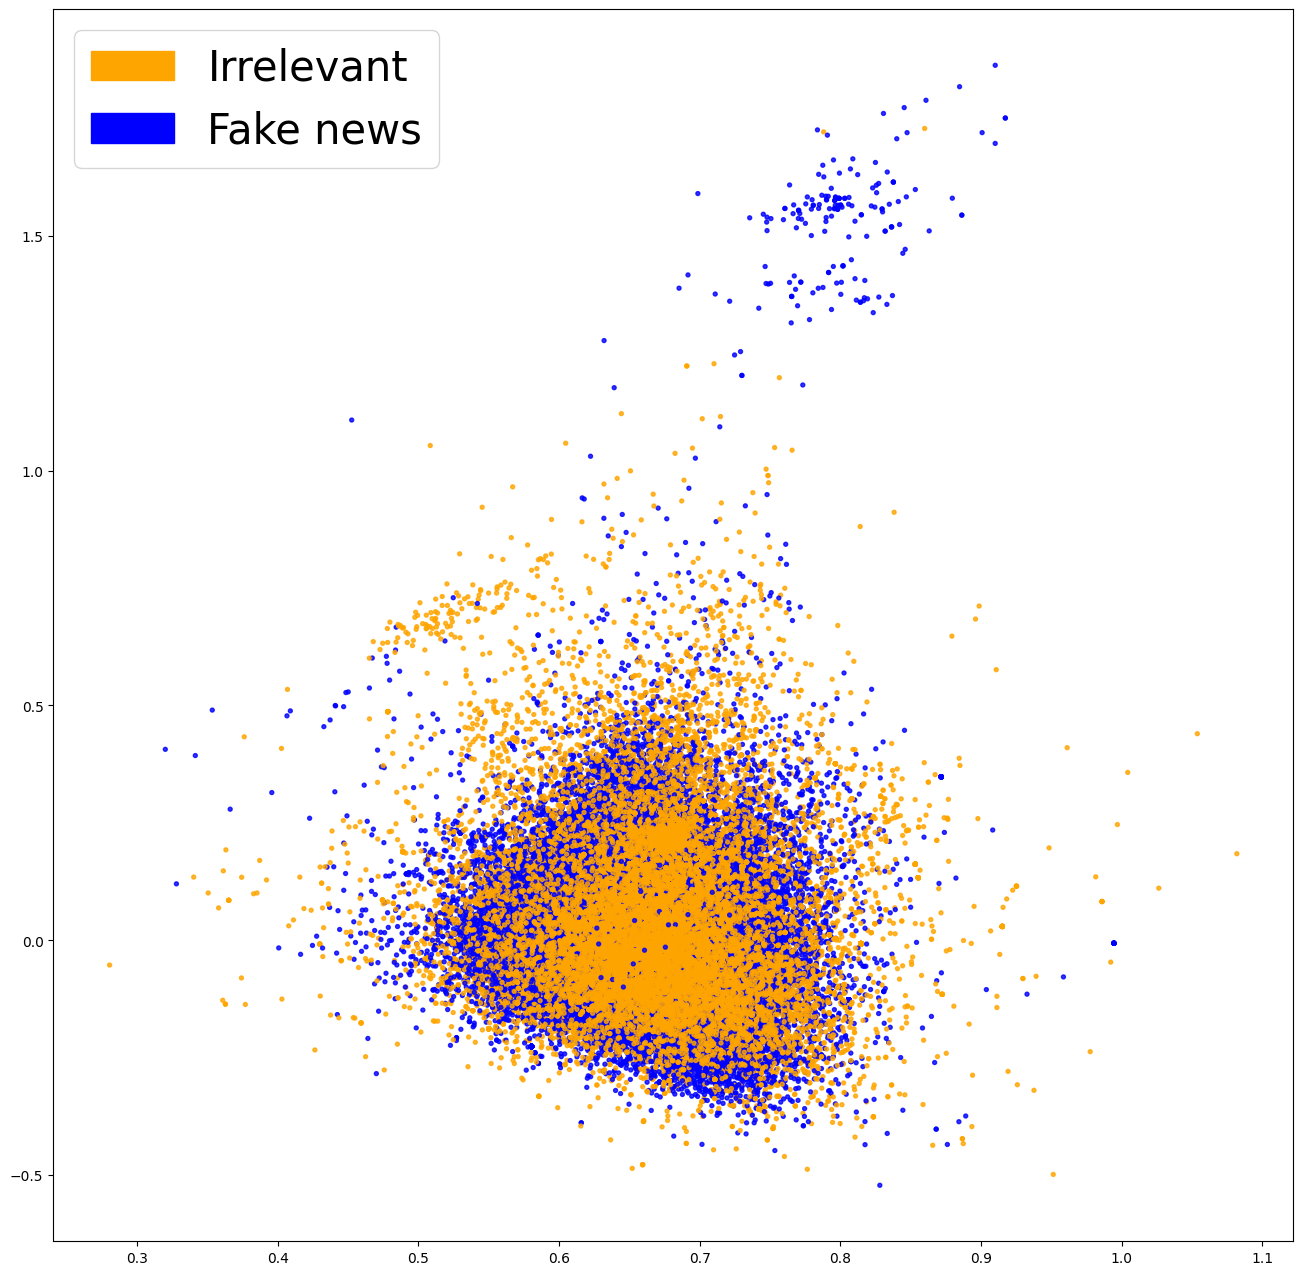

In [15]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression

clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [20]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.855, precision = 0.856, recall = 0.855, f1 = 0.855


In [40]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 1000
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(dataset["content"].tolist())
sequences = tokenizer.texts_to_sequences(dataset["content"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
labels = to_categorical(np.asarray(dataset["type"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 272496 unique tokens.
(272497, 300)


In [14]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [41]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]


In [15]:

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(dataset["type"].unique())), False)

In [24]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)


Epoch 1/3
597/597 [==============================] - 1054s 2s/step - loss: 0.3558 - acc: 0.9196 - val_loss: 0.2110 - val_acc: 0.9570
Epoch 2/3
597/597 [==============================] - 1014s 2s/step - loss: 0.1719 - acc: 0.9630 - val_loss: 0.1547 - val_acc: 0.9599
Epoch 3/3
597/597 [==============================] - 1084s 2s/step - loss: 0.1266 - acc: 0.9695 - val_loss: 0.1291 - val_acc: 0.9632


In [23]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

597/597 [==============================] - 75s 125ms/step


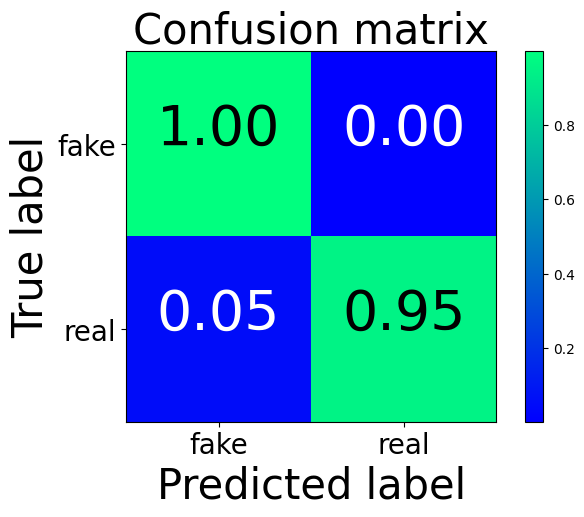

In [44]:
# make predictions from test set
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)

# get confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
plot_confusion_matrix(cm, classes=['fake', 'real'], normalize=True)
plt.show()


In [16]:
# laod in previously saved model
model.load_weights('E:/ML/DS_fake_news/cnn_model_b.h5')
# load tokenizer from pickle file
import pickle
with open('E:/ML/DS_fake_news/tokenizer_b.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [25]:

# saving the model and tokenizer
model.save('E:/ML/DS_fake_news/cnn_model_b.h5')
import pickle
with open('E:/ML/DS_fake_news/tokenizer_b.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [17]:
# laod in row 100000 to 120000
df = pd.read_csv('E:/ML/DS_fake_news/fake_news_cleaned_filtered.csv', nrows=100000, skiprows=range(1, 100000), usecols=['0'])
labels = pd.read_csv('E:/ML/DS_fake_news/fake_news_cleaned.csv', nrows=100000, skiprows=range(1, 100000), usecols=['type'])
# combine the two dataframes
df = pd.concat([df, labels], axis=1)
df['type'] = df['type'].map(label_map)
df = df[(df['type'] == 0) | (df['type'] == 1)]

df['0'] = df['0'].apply(ast.literal_eval)
df['content'] = df['0'].apply(lambda x: ' '.join(x))

In [18]:
test_data = df

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# run the model on the test data
test_sequences = tokenizer.texts_to_sequences(test_data["content"].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
predictions = model.predict(test_data)


3024/3024 [==============================] - 407s 119ms/step


NameError: name 'accuracy_score' is not defined

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
# print metrics
print("Accuracy: ", accuracy_score(df["type"], np.argmax(predictions, axis=1)))
print("Precision: ", precision_score(df["type"], np.argmax(predictions, axis=1), average='weighted'))
print("Recall: ", recall_score(df["type"], np.argmax(predictions, axis=1), average='weighted'))
print("F1: ", f1_score(df["type"], np.argmax(predictions, axis=1), average='weighted'))


Accuracy:  0.955446465481604
Precision:  0.9458102680597695
Recall:  0.955446465481604
F1:  0.9494993266299157


In [ ]:
# plot confusion matrix


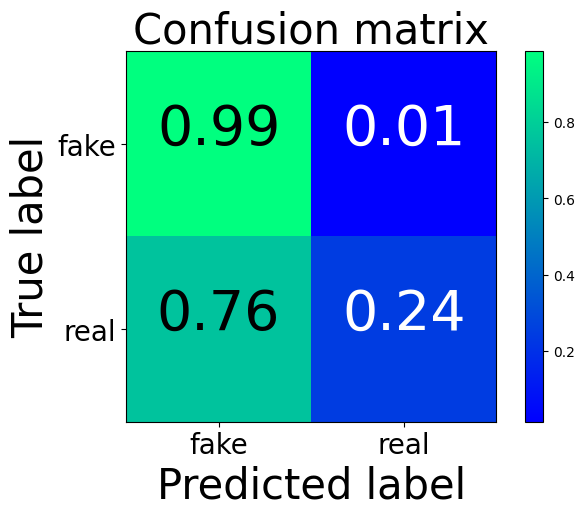

In [26]:
from sklearn.metrics import confusion_matrix
# create a confusion matrix
cm = confusion_matrix(df["type"], np.argmax(predictions, axis=1))
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['fake', 'real'], normalize=True, title='Confusion matrix')
plt.show()


In [27]:
# test on LIAR dataset as tsv file
df = pd.read_csv('E:/ML/DS_fake_news/train.tsv', sep='\t', header=None, usecols=[1,2])
liar_labels = {
    'false': 1,
    'pants-fire': 1,
    'barely-true': 1,
    'mostly-true': 0,
    'true': 0,
    'half-true': 0
}
df[1] = df[1].map(liar_labels)

In [28]:
# run the model on the test data
test_sequences = tokenizer.texts_to_sequences(df[2].tolist())
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
predictions = model.predict(test_data)

# print metrics
print("Accuracy: ", accuracy_score(df[1], np.argmax(predictions, axis=1)))
print("Precision: ", precision_score(df[1], np.argmax(predictions, axis=1), average='weighted'))
print("Recall: ", recall_score(df[1], np.argmax(predictions, axis=1), average='weighted'))
print("F1: ", f1_score(df[1], np.argmax(predictions, axis=1), average='weighted'))

320/320 [==============================] - 41s 128ms/step
Accuracy:  0.5615234375
Precision:  0.5127673984833659
Recall:  0.5615234375
F1:  0.40556009948282384


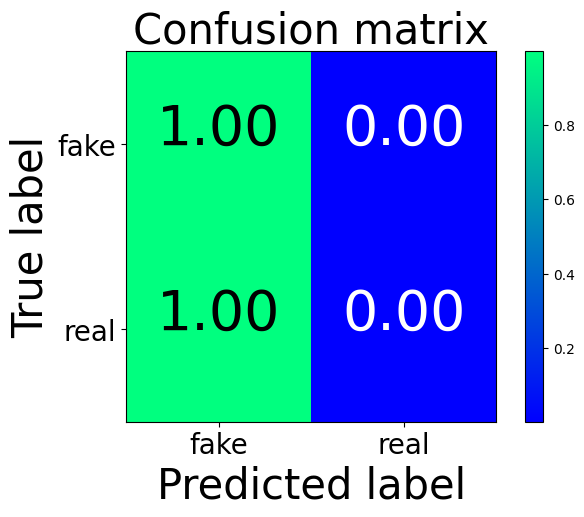

In [29]:
# plot the confusion matrix
cm = confusion_matrix(df[1], np.argmax(predictions, axis=1))
plot_confusion_matrix(cm, classes=['fake', 'real'], normalize=True, title='Confusion matrix')
plt.show()